Name: Jason Guerrero <br/>
USCID: 5466170786 <br/>
GitHub: JasonTGuerrero <br/>

#### imports

In [1]:
import keras
import os
import re
import string
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score


In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jasonguerrero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
print(keras.__version__)

3.4.1


# 1. Text Classification

### (a) Text Classification

In [4]:
POSPATH = "../data/pos/"
NEGPATH = "../data/neg/"

### (b) Data Exploration and Pre-processing

#### (i)

In [5]:
# You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.
def encode_sentiments(folder_path, label):
	encoding = {}
	for filename in os.listdir(folder_path):
		if filename.endswith('.txt'):
			encoding[filename] = label
	return encoding

pos_encoding = encode_sentiments(POSPATH, 1)
neg_encoding = encode_sentiments(NEGPATH, -1)
print(pos_encoding)
print(neg_encoding)

{'cv839_21467.txt': 1, 'cv034_29647.txt': 1, 'cv908_16009.txt': 1, 'cv748_12786.txt': 1, 'cv253_10077.txt': 1, 'cv147_21193.txt': 1, 'cv962_9803.txt': 1, 'cv686_13900.txt': 1, 'cv410_24266.txt': 1, 'cv913_29252.txt': 1, 'cv695_21108.txt': 1, 'cv601_23453.txt': 1, 'cv490_17872.txt': 1, 'cv518_13331.txt': 1, 'cv157_29372.txt': 1, 'cv570_29082.txt': 1, 'cv289_6463.txt': 1, 'cv098_15435.txt': 1, 'cv656_24201.txt': 1, 'cv878_15694.txt': 1, 'cv172_11131.txt': 1, 'cv152_8736.txt': 1, 'cv762_13927.txt': 1, 'cv028_26746.txt': 1, 'cv756_22540.txt': 1, 'cv595_25335.txt': 1, 'cv701_14252.txt': 1, 'cv407_22637.txt': 1, 'cv794_15868.txt': 1, 'cv000_29590.txt': 1, 'cv375_9929.txt': 1, 'cv891_6385.txt': 1, 'cv198_18180.txt': 1, 'cv161_11425.txt': 1, 'cv440_15243.txt': 1, 'cv497_26980.txt': 1, 'cv090_0042.txt': 1, 'cv382_7897.txt': 1, 'cv383_13116.txt': 1, 'cv625_12440.txt': 1, 'cv234_20643.txt': 1, 'cv217_28842.txt': 1, 'cv545_12014.txt': 1, 'cv367_22792.txt': 1, 'cv209_29118.txt': 1, 'cv449_8785.txt'

#### (ii)

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def process_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
            cleaned_content = preprocess_text(content)
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(cleaned_content)
            # print(f'Processed file: {filename}')

process_files_in_folder(POSPATH)
process_files_in_folder(NEGPATH)

#### (iii)

In [7]:
pos = glob.glob("../data/pos/*.txt")
neg = glob.glob("../data/neg/*.txt")

total_sentiments = pos + neg
l = [pd.read_csv(filename) for filename in total_sentiments]
assert len(total_sentiments) == len(pos) + len(neg)

In [8]:
pos_train_files = pd.DataFrame(pos)[0].sort_values()[0:700]
pos_test_files = pd.DataFrame(pos)[0].sort_values()[700:]
neg_train_files = pd.DataFrame(neg)[0].sort_values()[0:700]
neg_test_files = pd.DataFrame(neg)[0].sort_values()[700:]

In [9]:
pos_train_files

29     ../data/pos/cv000_29590.txt
621    ../data/pos/cv001_18431.txt
390    ../data/pos/cv002_15918.txt
396    ../data/pos/cv003_11664.txt
708    ../data/pos/cv004_11636.txt
                  ...             
10     ../data/pos/cv695_21108.txt
835    ../data/pos/cv696_29740.txt
382    ../data/pos/cv697_11162.txt
124    ../data/pos/cv698_15253.txt
963     ../data/pos/cv699_7223.txt
Name: 0, Length: 700, dtype: object

#### (iv)

In [10]:
unique_words = set()

for review in total_sentiments:
	# with open('../data/neg/cv000_29416.txt') as file:
	with open(review) as file:
		text = file.read()
		words_in_text = word_tokenize(text)
		for word in words_in_text:
			unique_words.add(word)

print(f"number of unique words: {len(unique_words)}")

number of unique words: 46825


#### (v)

In [11]:
review_lengths_data = []

for review in total_sentiments:
	# with open('../data/neg/cv000_29416.txt') as file:
	with open(review) as file:
		text = file.read()
		tokens = word_tokenize(text)
		filename = review.split("/")[-1]
		word_count = len(tokens)
		review_lengths_data.append([filename, word_count])

review_lengths_df = pd.DataFrame(review_lengths_data, columns=["Filename", "Word Count"])
review_lengths_df

,Filename,Word Count
0,cv839_21467.txt,790
1,cv034_29647.txt,616
2,cv908_16009.txt,1589
3,cv748_12786.txt,423
4,cv253_10077.txt,278
...,...,...
1995,cv159_29374.txt,302
1996,cv085_15286.txt,528
1997,cv081_18241.txt,270
1998,cv012_29411.txt,451


In [12]:
mean_word_count = review_lengths_df["Word Count"].mean()
print(f"Average Review Length: {mean_word_count}")

std_word_count = review_lengths_df["Word Count"].std()
print(f"Review Length Standard Deviation: {std_word_count}")


Average Review Length: 644.473
Review Length Standard Deviation: 285.09774048879467


#### (vi)

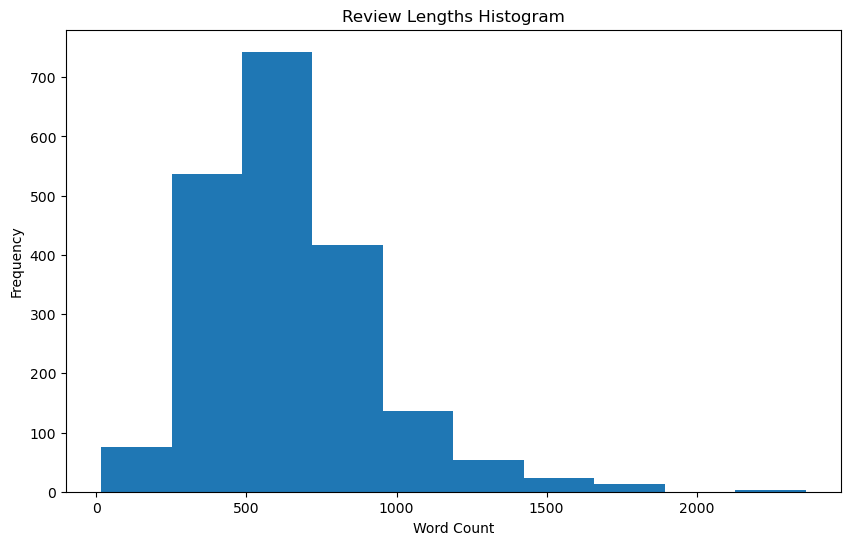

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths_df["Word Count"])
plt.title('Review Lengths Histogram')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

#### (vii)

In [14]:
texts = []
total_sentiments = sorted(total_sentiments)
for review in total_sentiments:
    with open(review, 'r', encoding='utf-8') as file:
        text = file.read()
        texts.append(text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

rank_data = []
for review, sequence in zip(total_sentiments, sequences):
    filename = review.split("/")[-1]
    rank_data.append([filename, sequence])

sequences_df = pd.DataFrame(rank_data, columns=['Filename', 'Word Ranks'])
word_index_df = pd.DataFrame(list(word_index.items()), columns=['Word', 'Rank']).sort_values(by='Rank')

display(sequences_df)
display(word_index_df)

,Filename,Word Ranks
0,cv000_29416.txt,"[98, 79, 1078, 3641, 129, 5, 2, 1966, 782, 364..."
1,cv001_19502.txt,"[1, 674, 6289, 1047, 27, 455, 1526, 8, 14977, ..."
2,cv002_17424.txt,"[9, 6, 101, 39, 110, 8, 86, 2, 7661, 27, 712, ..."
3,cv003_12683.txt,"[1914, 12, 8125, 6, 2750, 4627, 80, 7260, 2734..."
4,cv004_12641.txt,"[1968, 2, 3480, 6599, 116, 17381, 20942, 2915,..."
...,...,...
1995,cv995_21821.txt,"[4094, 48, 2, 27, 23, 267, 2, 27, 64, 22, 176,..."
1996,cv996_11592.txt,"[882, 3377, 64, 22, 2, 3840, 275, 16, 122, 25,..."
1997,cv997_5046.txt,"[46800, 1196, 2476, 4252, 1861, 3, 2529, 46801..."
1998,cv998_14111.txt,"[1004, 3841, 369, 1406, 15, 19, 148, 391, 1025..."


,Word,Rank
0,the,1
1,a,2
2,and,3
3,of,4
4,to,5
...,...,...
46825,tangerine,46826
46826,timbre,46827
46827,powaqqatsi,46828
46828,keyboardist,46829


#### (viii)

In [15]:
sorted_review_lengths_df = review_lengths_df.sort_values(by="Word Count")
sorted_review_lengths_df

,Filename,Word Count
1051,cv506_17521.txt,16
1959,cv779_18989.txt,65
1755,cv857_17527.txt,103
574,cv280_8267.txt,112
1091,cv435_24355.txt,119
...,...,...
268,cv146_18458.txt,1844
651,cv638_2953.txt,1879
650,cv765_19037.txt,2190
725,cv597_26360.txt,2264


In [16]:
L = sorted_review_lengths_df["Word Count"].quantile(0.70)
L = int(L)
L

737

In [17]:
sorted_review_lengths_df[sorted_review_lengths_df["Word Count"] > 737]

,Filename,Word Count
1993,cv486_9788.txt,738
208,cv884_13632.txt,738
923,cv604_2230.txt,738
1655,cv636_16954.txt,739
1220,cv963_7208.txt,739
...,...,...
268,cv146_18458.txt,1844
651,cv638_2953.txt,1879
650,cv765_19037.txt,2190
725,cv597_26360.txt,2264


#### (ix)

In [18]:
padded_sequences = pad_sequences(sequences, maxlen=L, padding='post', truncating='post')

padded_rank_data = []
for review, sequence in zip(total_sentiments, padded_sequences):
    filename = review.split("/")[-1]
    padded_rank_data.append([filename, sequence])

padded_sequences_df = pd.DataFrame(padded_rank_data, columns=['Filename', 'Padded Word Ranks'])

display(padded_sequences_df)
padded_sequences_df['Padded Word Ranks']

,Filename,Padded Word Ranks
0,cv000_29416.txt,"[98, 79, 1078, 3641, 129, 5, 2, 1966, 782, 364..."
1,cv001_19502.txt,"[1, 674, 6289, 1047, 27, 455, 1526, 8, 14977, ..."
2,cv002_17424.txt,"[9, 6, 101, 39, 110, 8, 86, 2, 7661, 27, 712, ..."
3,cv003_12683.txt,"[1914, 12, 8125, 6, 2750, 4627, 80, 7260, 2734..."
4,cv004_12641.txt,"[1968, 2, 3480, 6599, 116, 17381, 20942, 2915,..."
...,...,...
1995,cv995_21821.txt,"[4094, 48, 2, 27, 23, 267, 2, 27, 64, 22, 176,..."
1996,cv996_11592.txt,"[882, 3377, 64, 22, 2, 3840, 275, 16, 122, 25,..."
1997,cv997_5046.txt,"[46800, 1196, 2476, 4252, 1861, 3, 2529, 46801..."
1998,cv998_14111.txt,"[1004, 3841, 369, 1406, 15, 19, 148, 391, 1025..."


0       [98, 79, 1078, 3641, 129, 5, 2, 1966, 782, 364...
1       [1, 674, 6289, 1047, 27, 455, 1526, 8, 14977, ...
2       [9, 6, 101, 39, 110, 8, 86, 2, 7661, 27, 712, ...
3       [1914, 12, 8125, 6, 2750, 4627, 80, 7260, 2734...
4       [1968, 2, 3480, 6599, 116, 17381, 20942, 2915,...
                              ...                        
1995    [4094, 48, 2, 27, 23, 267, 2, 27, 64, 22, 176,...
1996    [882, 3377, 64, 22, 2, 3840, 275, 16, 122, 25,...
1997    [46800, 1196, 2476, 4252, 1861, 3, 2529, 46801...
1998    [1004, 3841, 369, 1406, 15, 19, 148, 391, 1025...
1999    [1028, 46817, 6285, 6, 1, 402, 354, 12, 772, 4...
Name: Padded Word Ranks, Length: 2000, dtype: object

In [19]:
print(padded_sequences_df['Padded Word Ranks'][0].shape)

(737,)


### (c) Word Embeddings

#### (i)

In [20]:
top_words = 5000
embedding_dim = 32

model = Sequential()
model.add(Embedding(input_dim=top_words, output_dim=embedding_dim, input_length=L))

/opt/anaconda3/envs/dsci552/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
def replace_out_of_range(arr):
    return np.where((arr >= 1) & (arr <= 4999), arr, 0)

padded_sequences_df['Padded Word Ranks'] = padded_sequences_df['Padded Word Ranks'].apply(replace_out_of_range)

In [22]:
sentiments = [-1] * 1000 + [1] * 1000
padded_sequences_df['Sentiment'] = sentiments
padded_sequences_df

,Filename,Padded Word Ranks,Sentiment
0,cv000_29416.txt,"[98, 79, 1078, 3641, 129, 5, 2, 1966, 782, 364...",-1
1,cv001_19502.txt,"[1, 674, 0, 1047, 27, 455, 1526, 8, 0, 2912, 2...",-1
2,cv002_17424.txt,"[9, 6, 101, 39, 110, 8, 86, 2, 0, 27, 712, 0, ...",-1
3,cv003_12683.txt,"[1914, 12, 0, 6, 2750, 4627, 80, 0, 0, 505, 5,...",-1
4,cv004_12641.txt,"[1968, 2, 3480, 0, 116, 0, 0, 2915, 2, 411, 29...",-1
...,...,...,...
1995,cv995_21821.txt,"[4094, 48, 2, 27, 23, 267, 2, 27, 64, 22, 176,...",1
1996,cv996_11592.txt,"[882, 3377, 64, 22, 2, 3840, 275, 16, 122, 25,...",1
1997,cv997_5046.txt,"[0, 1196, 2476, 4252, 1861, 3, 2529, 0, 1, 344...",1
1998,cv998_14111.txt,"[1004, 3841, 369, 1406, 15, 19, 148, 391, 1025...",1


In [23]:
neg_train_padded_sequences_df = padded_sequences_df[:700]
neg_test_padded_sequences_df = padded_sequences_df[700:1000]
pos_train_padded_sequences_df = padded_sequences_df[1000:1700]
pos_test_padded_sequences_df = padded_sequences_df[1700:]
train_labels = pd.concat([padded_sequences_df['Sentiment'][:700], padded_sequences_df['Sentiment'][1000:1700]], ignore_index=True)
test_labels = pd.concat([padded_sequences_df['Sentiment'][700:1000], padded_sequences_df['Sentiment'][1700:]], ignore_index=True)

train_padded_sequences_df = pd.concat([neg_train_padded_sequences_df, pos_train_padded_sequences_df], ignore_index=True)
test_padded_sequences_df = pd.concat([neg_test_padded_sequences_df, pos_test_padded_sequences_df], ignore_index=True)
display(train_padded_sequences_df)
display(test_padded_sequences_df)
display(train_labels)
display(test_labels)

,Filename,Padded Word Ranks,Sentiment
0,cv000_29416.txt,"[98, 79, 1078, 3641, 129, 5, 2, 1966, 782, 364...",-1
1,cv001_19502.txt,"[1, 674, 0, 1047, 27, 455, 1526, 8, 0, 2912, 2...",-1
2,cv002_17424.txt,"[9, 6, 101, 39, 110, 8, 86, 2, 0, 27, 712, 0, ...",-1
3,cv003_12683.txt,"[1914, 12, 0, 6, 2750, 4627, 80, 0, 0, 505, 5,...",-1
4,cv004_12641.txt,"[1968, 2, 3480, 0, 116, 0, 0, 2915, 2, 411, 29...",-1
...,...,...,...
1395,cv695_21108.txt,"[28, 69, 32, 360, 772, 1351, 88, 474, 43, 18, ...",1
1396,cv696_29740.txt,"[2549, 14, 6, 2, 0, 175, 30, 2, 1314, 0, 4982,...",1
1397,cv697_11162.txt,"[124, 2860, 15, 14, 182, 44, 31, 881, 21, 0, 1...",1
1398,cv698_15253.txt,"[2, 3395, 0, 6, 1, 0, 4, 2, 2632, 10, 2, 2334,...",1


,Filename,Padded Word Ranks,Sentiment
0,cv700_23163.txt,"[1, 1821, 6, 2, 0, 1429, 15, 8, 18, 64, 57, 19...",-1
1,cv701_15880.txt,"[1, 62, 2439, 1434, 4, 23, 2, 0, 46, 149, 4618...",-1
2,cv702_12371.txt,"[7, 1, 659, 631, 24, 0, 94, 27, 381, 1781, 297...",-1
3,cv703_17948.txt,"[110, 394, 60, 20, 0, 1, 0, 4, 67, 362, 19, 20...",-1
4,cv704_17622.txt,"[81, 127, 1579, 161, 18, 4611, 8, 1945, 2550, ...",-1
...,...,...,...
595,cv995_21821.txt,"[4094, 48, 2, 27, 23, 267, 2, 27, 64, 22, 176,...",1
596,cv996_11592.txt,"[882, 3377, 64, 22, 2, 3840, 275, 16, 122, 25,...",1
597,cv997_5046.txt,"[0, 1196, 2476, 4252, 1861, 3, 2529, 0, 1, 344...",1
598,cv998_14111.txt,"[1004, 3841, 369, 1406, 15, 19, 148, 391, 1025...",1


0      -1
1      -1
2      -1
3      -1
4      -1
       ..
1395    1
1396    1
1397    1
1398    1
1399    1
Name: Sentiment, Length: 1400, dtype: int64

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
595    1
596    1
597    1
598    1
599    1
Name: Sentiment, Length: 600, dtype: int64

In [24]:
train_tokens_matrix = train_padded_sequences_df['Padded Word Ranks'].to_numpy()
test_tokens_matrix = test_padded_sequences_df['Padded Word Ranks'].to_numpy()
train_tokens_matrix = np.array([np.array(lst) for lst in train_tokens_matrix])
test_tokens_matrix = np.array([np.array(lst) for lst in test_tokens_matrix])
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

print(f"train_tokens_matrix:\n{train_tokens_matrix.shape}\n{train_tokens_matrix}")
print()
print(f"test_tokens_matrix:\n{test_tokens_matrix.shape}\n{test_tokens_matrix}")
print("train labels:")
print(train_labels.shape)
print(train_labels)
print("test labels")
print(test_labels.shape)
print(test_labels)

train_tokens_matrix:
(1400, 737)
[[  98   79 1078 ...    0    0    0]
 [   1  674    0 ...    0    0    0]
 [   9    6  101 ...    0    0    0]
 ...
 [ 124 2860   15 ...    0    0    0]
 [   2 3395    0 ...   85    4    0]
 [  78  147  100 ...    0    0    0]]

test_tokens_matrix:
(600, 737)
[[   1 1821    6 ...    0    0    0]
 [   1   62 2439 ...    0    0    0]
 [   7    1  659 ...    0    0    0]
 ...
 [   0 1196 2476 ...    6  108 3216]
 [1004 3841  369 ...    0    0    0]
 [1028    0    0 ...  227   26 1719]]
train labels:
(1400,)
[-1 -1 -1 ...  1  1  1]
test labels
(600,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

In [25]:
train_tokens_matrix

array([[  98,   79, 1078, ...,    0,    0,    0],
       [   1,  674,    0, ...,    0,    0,    0],
       [   9,    6,  101, ...,    0,    0,    0],
       ...,
       [ 124, 2860,   15, ...,    0,    0,    0],
       [   2, 3395,    0, ...,   85,    4,    0],
       [  78,  147,  100, ...,    0,    0,    0]], dtype=int32)

In [26]:
tokens_matrix = np.vstack(padded_sequences_df['Padded Word Ranks'].to_numpy())
print(tokens_matrix.shape)
print(tokens_matrix)

(2000, 737)
[[  98   79 1078 ...    0    0    0]
 [   1  674    0 ...    0    0    0]
 [   9    6  101 ...    0    0    0]
 ...
 [   0 1196 2476 ...    6  108 3216]
 [1004 3841  369 ...    0    0    0]
 [1028    0    0 ...  227   26 1719]]


In [27]:
train_tokens_matrix

array([[  98,   79, 1078, ...,    0,    0,    0],
       [   1,  674,    0, ...,    0,    0,    0],
       [   9,    6,  101, ...,    0,    0,    0],
       ...,
       [ 124, 2860,   15, ...,    0,    0,    0],
       [   2, 3395,    0, ...,   85,    4,    0],
       [  78,  147,  100, ...,    0,    0,    0]], dtype=int32)

In [28]:
train_embeddings_matrix = model.predict(train_tokens_matrix)
test_embeddings_matrix = model.predict(test_tokens_matrix)
print(train_embeddings_matrix.shape)
print(test_embeddings_matrix.shape)
print(train_embeddings_matrix)
print(test_embeddings_matrix)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
(1400, 737, 32)
(600, 737, 32)
[[[ 0.03925676  0.03304542  0.04172217 ... -0.03614228 -0.04543976
   -0.01497326]
  [ 0.02836312 -0.04374274  0.02616371 ...  0.04891003 -0.02431585
    0.04505942]
  [-0.00052674  0.01896429  0.01779901 ...  0.02761943 -0.04287001
   -0.0261164 ]
  ...
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]]

 [[-0.04987419  0.03953192 -0.03945085 ... -0.04462079  0.0196293
    0.04866723]
  [-0.03372373  0.02600712  0.01134744 ...  0.00061792 -0.03395934
   -0.03049546]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  ...
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0.02635467  0.04998653 ... 

In [29]:
embeddings_matrix = model.predict(tokens_matrix)
print(embeddings_matrix.shape)
print(embeddings_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
(2000, 737, 32)
[[[ 0.03925676  0.03304542  0.04172217 ... -0.03614228 -0.04543976
   -0.01497326]
  [ 0.02836312 -0.04374274  0.02616371 ...  0.04891003 -0.02431585
    0.04505942]
  [-0.00052674  0.01896429  0.01779901 ...  0.02761943 -0.04287001
   -0.0261164 ]
  ...
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]]

 [[-0.04987419  0.03953192 -0.03945085 ... -0.04462079  0.0196293
    0.04866723]
  [-0.03372373  0.02600712  0.01134744 ...  0.00061792 -0.03395934
   -0.03049546]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  ...
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
   -0.0249073 ]
  [-0.02765656 -0

In [30]:
print(embeddings_matrix[0].shape)
print(embeddings_matrix[0])

(737, 32)
[[ 0.03925676  0.03304542  0.04172217 ... -0.03614228 -0.04543976
  -0.01497326]
 [ 0.02836312 -0.04374274  0.02616371 ...  0.04891003 -0.02431585
   0.04505942]
 [-0.00052674  0.01896429  0.01779901 ...  0.02761943 -0.04287001
  -0.0261164 ]
 ...
 [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.02765656 -0.02635467  0.04998653 ...  0.00771065  0.04405988
  -0.0249073 ]]


#### (ii)

In [31]:
flattened_embeddings_matrix = embeddings_matrix.reshape(2000, 737 * 32)
print(flattened_embeddings_matrix.shape)
print(flattened_embeddings_matrix)

(2000, 23584)
[[ 0.03925676  0.03304542  0.04172217 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04763654  0.01742664 -0.02228661 ...  0.00771065  0.04405988
  -0.0249073 ]
 ...
 [-0.02765656 -0.02635467  0.04998653 ...  0.03293723 -0.03853252
   0.03860709]
 [-0.04278513  0.02390606  0.00973767 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.0074226  -0.02335132  0.03274801 ...  0.02246121 -0.04567522
   0.00639751]]


In [32]:
print(flattened_embeddings_matrix[0].shape)
print(flattened_embeddings_matrix[0])

(23584,)
[ 0.03925676  0.03304542  0.04172217 ...  0.00771065  0.04405988
 -0.0249073 ]


In [33]:
flattened_train_embeddings_matrix = train_embeddings_matrix.reshape(1400, 737 * 32)
flattened_test_embeddings_matrix = test_embeddings_matrix.reshape(600, 737 * 32)
print(flattened_train_embeddings_matrix.shape)
print(flattened_train_embeddings_matrix)
print(flattened_test_embeddings_matrix.shape)
print(flattened_test_embeddings_matrix)

(1400, 23584)
[[ 0.03925676  0.03304542  0.04172217 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04763654  0.01742664 -0.02228661 ...  0.00771065  0.04405988
  -0.0249073 ]
 ...
 [-0.00263736  0.02807606 -0.04577314 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.04790515 -0.00057345  0.01550138 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.02195717  0.03610816 -0.00108435 ...  0.00771065  0.04405988
  -0.0249073 ]]
(600, 23584)
[[-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.01734027 -0.00104775 -0.03079507 ...  0.00771065  0.04405988
  -0.0249073 ]
 ...
 [-0.02765656 -0.02635467  0.04998653 ...  0.03293723 -0.03853252
   0.03860709]
 [-0.04278513  0.02390606  0.00973767 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.0074226  -0.02335132  0.03274801 ...  0.02246121 -0.04567522
   0.

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 737, 32)          │       160,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

### (d) Multi-Layer Perceptron

In [35]:
labels = np.vstack(padded_sequences_df['Sentiment'].to_numpy())

features = embeddings_matrix

print(features.shape, labels.shape)

(2000, 737, 32) (2000, 1)


#### (i)

In [38]:
mlp = Sequential()

# mlp.add(Input(shape=(L * 32,)))
# mlp.add(Embedding(input_dim=5000, output_dim=32, input_length=L))
mlp.add(Dense(50, activation='relu'))
mlp.add(Dropout(0.2))

mlp.add(Dense(50, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(50, activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
print(type(flattened_train_embeddings_matrix))
print(type(train_labels))
print(flattened_train_embeddings_matrix.shape)
print(len(train_labels))
print(train_labels)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1400, 23584)
1400
[-1 -1 -1 ...  1  1  1]


In [40]:
tensor_flattened_train_embeddings_matrix = np.array([tf.convert_to_tensor(sub_arr) for sub_arr in flattened_train_embeddings_matrix])
tensor_flattened_test_embeddings_matrix = np.array([tf.convert_to_tensor(sub_arr) for sub_arr in flattened_test_embeddings_matrix])
train_labels[train_labels == -1] = 0
test_labels[test_labels == -1] = 0
tensor_train_labels = tf.convert_to_tensor(train_labels)
tensor_test_labels = tf.convert_to_tensor(test_labels)
print(tensor_flattened_train_embeddings_matrix.shape)
print(tensor_flattened_train_embeddings_matrix)
print(tensor_flattened_test_embeddings_matrix.shape)
print(tensor_flattened_test_embeddings_matrix)

(1400, 23584)
[[ 0.03925676  0.03304542  0.04172217 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04763654  0.01742664 -0.02228661 ...  0.00771065  0.04405988
  -0.0249073 ]
 ...
 [-0.00263736  0.02807606 -0.04577314 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.04790515 -0.00057345  0.01550138 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.02195717  0.03610816 -0.00108435 ...  0.00771065  0.04405988
  -0.0249073 ]]
(600, 23584)
[[-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.04987419  0.03953192 -0.03945085 ...  0.00771065  0.04405988
  -0.0249073 ]
 [-0.01734027 -0.00104775 -0.03079507 ...  0.00771065  0.04405988
  -0.0249073 ]
 ...
 [-0.02765656 -0.02635467  0.04998653 ...  0.03293723 -0.03853252
   0.03860709]
 [-0.04278513  0.02390606  0.00973767 ...  0.00771065  0.04405988
  -0.0249073 ]
 [ 0.0074226  -0.02335132  0.03274801 ...  0.02246121 -0.04567522
   0.

In [41]:
print(tensor_train_labels)
print(tensor_test_labels)

tf.Tensor([0 0 0 ... 1 1 1], shape=(1400,), dtype=int64)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [42]:
print(tensor_train_labels)
print(tensor_test_labels)

tf.Tensor([0 0 0 ... 1 1 1], shape=(1400,), dtype=int64)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [43]:
mlp.fit(tensor_flattened_train_embeddings_matrix, tensor_train_labels, epochs=2, batch_size=10)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5271 - loss: 0.7033
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5787 - loss: 0.6808


#### (ii)

In [44]:
test_loss, test_accuracy = mlp.evaluate(tensor_flattened_test_embeddings_matrix, tensor_test_labels)
train_loss, train_accuracy = mlp.evaluate(tensor_flattened_train_embeddings_matrix, tensor_train_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2042 - loss: 0.7173    
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.4259 - loss: 0.6884


In [45]:
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Loss: {train_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Train Accuracy: 0.6449999809265137
Train Loss: 0.656080424785614
Test Accuracy: 0.5049999952316284
Test Loss: 0.6914283037185669


### (e) One-Dimensional Convolutional Neural Network:

#### (i)

In [46]:
cnn = Sequential()
cnn.add(Embedding(input_dim=top_words, output_dim=32, input_length=L))
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2, strides=2))
cnn.add(Flatten())
cnn.add(Dense(250, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn.summary()

/opt/anaconda3/envs/dsci552/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### (ii)

In [47]:
train_token_features = np.concatenate((tokens_matrix[:700], tokens_matrix[1000:1700]))
test_token_features = np.vstack((tokens_matrix[700:1000], tokens_matrix[1700:]))

train_token_features.shape, test_token_features.shape

((1400, 737), (600, 737))

In [48]:
cnn.fit(train_token_features, train_labels, epochs=2, batch_size=10)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5232 - loss: 0.7334
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6346 - loss: 0.6413


In [49]:
test_loss, test_accuracy = cnn.evaluate(test_token_features, test_labels, verbose=0)
train_loss, train_accuracy = cnn.evaluate(train_token_features, train_labels, verbose=0)

In [50]:
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Loss: {train_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Train Accuracy: 0.7478571534156799
Train Loss: 0.43426474928855896
Test Accuracy: 0.5916666388511658
Test Loss: 0.7241743206977844


### (f) Long Short-Term Memory Recurrent Neural Network:

#### (i)

In [51]:
lstm = Sequential([
    LSTM(32, return_sequences=False, input_shape=(737, 32), dropout=0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

/opt/anaconda3/envs/dsci552/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
train_embeddings_matrix.shape, train_labels.shape

((1400, 737, 32), (1400,))

In [53]:
lstm.fit(train_embeddings_matrix, train_labels, epochs=10, batch_size=10)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4738 - loss: 0.6937
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5270 - loss: 0.6968
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5571 - loss: 0.6858
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5634 - loss: 0.6859
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5230 - loss: 0.6949
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5442 - loss: 0.6870
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5559 - loss: 0.6861
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5754 - loss: 0.6798
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5530 - loss: 0.6858
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5317 - loss: 0.6894


#### (ii)

In [54]:
test_loss, test_accuracy = lstm.evaluate(test_embeddings_matrix, test_labels)
train_loss, train_accuracy = lstm.evaluate(train_embeddings_matrix, train_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6673 - loss: 0.6766
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7039 - loss: 0.6716


In [55]:
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Loss: {train_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Train Accuracy: 0.5557143092155457
Train Loss: 0.685615599155426
Test Accuracy: 0.5533333420753479
Test Loss: 0.685391366481781
